# GWAS Prediction

In [308]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
import plotnine as p9
import scipy.stats
from plotnine import *
from torcheval.metrics import R2Score
import torch
from scipy.stats import wilcoxon, ttest_rel, ranksums
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preparation

### Load Covariates

In [309]:
def build_control_covariates(metadata):
    genesize = metadata.NPARAM.values.astype(float)
    genedensity = metadata.NPARAM.values/metadata.NSNPS.values
    inverse_mac = 1.0/metadata.MAC.values
    cov = np.stack((genesize, np.log(genesize), genedensity, np.log(genedensity), inverse_mac, np.log(inverse_mac)), axis=1)
    return cov

def munge_sigma(magma_gene_raw):
    f = open(magma_gene_raw)
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    sigmas = []
    gene_metadata = []
    gene_lists = []
    for chrom in range(1,23):
        chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
        chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
        lines_chr = lines[chr_start:chr_end+1]
        n_genes = len(lines_chr)
        sigma_chr = np.zeros([n_genes, n_genes])
        gene_NSNPs = np.zeros(n_genes)
        gene_NPARAM = np.zeros(n_genes)
        gene_MAC = np.zeros(n_genes)
        for i in range(n_genes):
            line = lines_chr[i]
            gene_NSNPs[i] = line[4]
            gene_NPARAM[i] = line[5]
            gene_MAC[i] = line[7]
            if line.shape[0] > 9:
                gene_corrs = np.asarray([float(c) for c in line[9:]])
                sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
        sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
        sigmas.append(sigma_chr)
        gene_metadata_chr = pd.DataFrame(data={'NSNPS': gene_NSNPs, 'NPARAM': gene_NPARAM, 'MAC': gene_MAC})
        gene_metadata.append(gene_metadata_chr)
        gene_list_chr = [line[0] for line in lines_chr]
        gene_lists.append(gene_list_chr)
    return sigmas, gene_metadata, gene_lists

In [310]:
def get_covariates(metadata, gene_lists):
    # create covariates from pops
    covariates = []
    for i in range(0, 22):
        #print(i)
        covariates.append(pd.DataFrame(build_control_covariates(metadata[i]),
                                       index = gene_lists[i],
                                       columns = ['genesize',
                                                  'log_genesize',
                                                  'genedensity',
                                                  'log_genedensity',
                                                  'inverse_mac',
                                                  'log_inverse_mac'])
                          )
    covariates = pd.concat(covariates)
    return covariates

### Load Embeddings

In [311]:
def get_embeddings(emb_name):
    emb_path = '../data/embeddings/'+emb_name+'.tsv'
    emb = pd.read_csv(emb_path, sep = "\t").set_index("gene_id")
    return emb

### Load GWAS MAGMA Scores

In [312]:
def load_magma(trait, covariates):
    magma = pd.read_csv('../data/input/GWAS/'+trait+'.genes.out', delim_whitespace=True)
    magma = magma.merge(covariates, left_on = "GENE", right_index = True)
    return magma

### Project Y to LY

In [313]:
def compute_Ls(sigmas, Y):
    Ls = []
    min_lambda=0
    for sigma in sigmas:
        W = np.linalg.eigvalsh(sigma)
        min_lambda = min(min_lambda, min(W))
    #Y = pd.read_table(args.gene_results+'.genes.out', delim_whitespace=True).ZSTAT.values
    ridge = abs(min_lambda)+.05+.9*max(0, np.var(Y)-1)
    for sigma in sigmas:
        sigma = sigma+ridge*np.identity(sigma.shape[0])
        L = np.linalg.cholesky(np.linalg.inv(sigma))
        Ls.append(L)
    return Ls

In [314]:
def project_Y(Ls, magma, gene_lists):
    LYs = []
    for i in range(22):
        L = Ls[i]
        magma_temp = magma.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": magma_temp.GENE, "LY": np.matmul(L, magma_temp.ZSTAT)}))
    return pd.concat(LYs)

def project_Y_back(Ls, res, gene_lists):
    LYs = []
    for i in range(22):
        L = np.linalg.inv(Ls[i])
        temp = res.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": temp.dropna().GENE,
                                 "pred": np.matmul(L[~temp.pred_LY.isna(), :][:, ~temp.pred_LY.isna()],
                                                   temp.dropna().pred_LY),
                                 }))
    return pd.concat(LYs)

### Merge Data

In [315]:
def prepare_data(trait, emb_name):
  sigmas, metadata, gene_lists = munge_sigma('../data/input/GWAS/'+trait+'.genes.raw')
  covariates = get_covariates(metadata, gene_lists)
  
  magma = load_magma(trait, covariates)

  if emb_name == "null":
    #emb = pd.DataFrame({'gene_id': [x for xs in gene_lists for x in xs], 'null': [0 for xs in gene_lists for x in xs]}).set_index("gene_id")
    emb = pd.DataFrame({'gene_id': [gene for gene in magma["GENE"]], 'null': [0 for gene in magma["GENE"]]}).set_index("gene_id")
  else:
    emb = get_embeddings(emb_name)
  
  # Add Ls
  Ls = compute_Ls(sigmas, magma.ZSTAT)
  magma = magma.merge(project_Y(Ls, magma, gene_lists))
  
  # Merge everything
  data = magma.merge(emb, left_on = "GENE", right_on = "gene_id")
  dict = {"sigmas": sigmas, "metadata": metadata, "gene_lists": gene_lists, "covariates": covariates, "embeddings": emb, "Ls": Ls}
  return data, dict, magma

## Regression

Split by Chromosomes.

In [316]:
def regression_chrom_cv(dt, emb_cols, Ls, gene_lists, complete_magma):
    cv_results = []
    
    for chrom in range(1,23):
        reg = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
        
        mod = reg.fit(
            dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
            dt.query("CHR != @chrom")['LY']
        )
        pred = mod.predict(
            dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        )
    
        results_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
        results_chrom['pred_LY'] = pred
    
        cv_results.append(results_chrom)
        #print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(results_chrom.LY, results_chrom.pred_LY_null)[0]**2}")
        #print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(results_chrom.LY, results_chrom.pred_LY)[0]**2}")
    
    #print()
    
    cv_results = pd.concat(cv_results)
    
    cv_results = cv_results.merge(project_Y_back(Ls, cv_results, gene_lists))
    
    # Filter & impute genes (for comparability)
    filtered_preds = cv_results[cv_results['GENE'].isin(complete_magma['GENE'])]
    missing_preds = complete_magma[~complete_magma['GENE'].isin(cv_results['GENE'])]
    mean_target = complete_magma['ZSTAT'].mean()
    for gene in missing_preds['GENE']:
        zstat = complete_magma[complete_magma['GENE'] == gene]['ZSTAT'].iloc[0]
        new_row = {'GENE': gene, 'pred': mean_target, 'ZSTAT': zstat}
        #filtered_preds = filtered_preds.append(new_row, ignore_index=True)
        filtered_preds = pd.concat([filtered_preds, pd.DataFrame([new_row])])
    
    r2 = scipy.stats.pearsonr(filtered_preds.ZSTAT, filtered_preds.pred)[0]**2
    print(f"Overall R2: {r2}")

    return cv_results, filtered_preds, r2

In [317]:
def get_results(traits, model_names):
    results = []
    for trait in traits:
        print("# Trait:", trait)
        
        for model in model_names:
            print("## Model:", model)
            data, metadata, complete_magma = prepare_data(trait, model)
            emb_cols = metadata["embeddings"].columns.to_list()
            Ls = metadata["Ls"]
            gene_lists = metadata["gene_lists"]
            #reg_results = regression_chrom_cv(data, emb_cols, Ls, gene_lists)
            cv_results, filtered_preds, r2 = regression_chrom_cv(data, emb_cols, Ls, gene_lists, complete_magma)
            
            r2_per_chrom=[]
            for i in range(1,23):
                df = filtered_preds.query("CHR == @i")
                r2_per_chrom.append(R2Score().update(torch.tensor(df["pred"].values), torch.tensor(df["ZSTAT"].values)).compute().numpy())
            
            res = {'trait': trait, 'name': model, 'r2': r2, 'cv_results': cv_results, 'filtered_preds': filtered_preds, 'r2_per_chrom': np.array(r2_per_chrom)}
            results.append(res)
            print()
    return results

## Plotting

In [318]:
def r2_per_chrom(results):

    plot_data = []
    
    for res in results:
        per_chrom_r2 = []
        for i in range(1, 23):
            res_tmp = reg_results.query("CHR == @i")
            r2 = scipy.stats.pearsonr(res_tmp.ZSTAT, res_tmp.pred)[0]**2
            per_chrom_r2.append(r2)
        
        chromosomes = list(range(1, 23))
        df = pd.DataFrame({'trait': res['trait'], 'model': res['name'], 'chrom': chromosomes, 'r2': per_chrom_r2})
        plot_data.append(df)

    plot_data = pd.concat(plot_data)
    
    return (ggplot(plot_data, aes(x='factor(chrom)', y='r2')) +
     facet_wrap(['trait', 'model']) +
     geom_bar(stat='identity') +
     labs(title='R² Across Chromosomes', x='Chromosome', y='R²'))

In [319]:
def scatterplot_all_models(results):
    plot_data = pd.DataFrame(results)[['trait', 'name', 'r2']]
    plot_data['null_r2'] = plot_data.groupby('trait')['r2'].transform(lambda x: x.iloc[0] if x.iloc[0] is not None else None)
    plot_data = plot_data[plot_data['name'] != 'null']
    return ggplot(plot_data, aes('null_r2', 'r2', color='trait')) + facet_wrap('name') + geom_point() + geom_abline(intercept = 0, slope = 1) + labs(title='Full Model vs. Covariate Model', x='Null model R²', y='Full model R²')

In [348]:
def heatmap_models_traits(res_df):
    heatmap_data = res_df.pivot(index='trait', columns='name', values='delta_r2').drop(['null'], axis=1)
    sns.set()
    plt.figure(figsize=(12, 8))
    h = sns.heatmap(heatmap_data, annot=True, linewidths=.5, cmap="Blues", fmt=".4f")
    #h.set_xticklabels(h.get_xticklabels(), rotation = 45)
    h.set_xlabel('Model')
    h.set_ylabel('Trait')
    plt.title('Delta R²')
    plt.show()

In [321]:
def boxplot_all_models(res_df):
    plot_data = res_df[res_df['name'] != 'null']
    return ggplot(plot_data, aes("name", "delta_r2")) + geom_boxplot() + labs(title='Comparison of Models across all Traits', x='Model', y='Delta R²')

In [332]:
# TODO Multiple testing correction?
def compare_against_null(results, alpha=0.05):
    plot_data = pd.DataFrame(results)[['trait', 'name', 'r2']]
    sig = []
    for idx, model in enumerate(models):
        if (model == 'null'):
            continue
        model_r2 = res_df[res_df['name'] == model]['r2']
        null_r2 = res_df[res_df['name'] == 'null']['r2']
        
        w_stat, p_val = wilcoxon(model_r2, null_r2)
        print(model, "p =", p_val)
        sig.append(pd.DataFrame({'model': model, 'p_val': p_val}, index=[idx-1]))
    sig = pd.concat(sig)
    plot_data = plot_data.merge(sig, how='left', left_on='name', right_on='model').drop('model', axis=1)
    plot_data['name'] = np.where(plot_data.p_val < alpha, plot_data.name + '*', plot_data.name)
    return ggplot(plot_data, aes('name', 'r2')) + geom_boxplot() + labs(title='Full Models vs. Covariate Model', x='Model', y='R²')

# Run

In [18]:
from os import walk
traits = []
filenames = next(walk("../data/input/GWAS"), (None, None, []))[2]  # [] if no file
for f in filenames:
    if (len(f.split(".genes.")) == 2 and f.split(".genes.")[1] == "raw"):
        traits.append(f.split(".genes.")[0])
traits

['LDL_direct',
 'Calcium_30680',
 'HDL_cholesterol',
 'Lipoprotein_A',
 'Apolipoprotein_B',
 'Direct_bilirubin',
 'Vitamin_D',
 'HDL',
 'RBC',
 'Testosterone',
 'Alanine_aminotransferase',
 'Triglycerides',
 'Mean_corpuscular_haemoglobin',
 'Total_bilirubin',
 'IGF-1',
 'LDL_direct_adjusted_by_medication',
 'C-reactive_protein',
 'Phosphate',
 'Red_blood_cell_erythrocyte_count',
 'Albumin',
 'MCH',
 'Creatinine',
 'Cholesterol',
 'LDLC',
 'Total_protein',
 'Urate',
 'Apolipoprotein_A',
 'SHBG',
 'Glucose',
 'Calcium_100024']

In [50]:
models = ["null", "Omics_d256", "GTEx_PCA_d64", "DepMap_PCs_d81_0.92Variance", "DepMap_ae_d128", "DepMap_DVTFM_d128", "TS_pb_PCs_d5_0.8Variance", "TS_pb_ae_d64", "TS_pb_DVTFM_d256", "rna_PCs_d4_0.95Variance", "rna_ae_d32"]
models

['null',
 'Omics_d256',
 'GTEx_PCA_d64',
 'DepMap_PCs_d81_0.92Variance',
 'DepMap_ae_d128',
 'DepMap_DVTFM_d128',
 'TS_pb_PCs_d5_0.8Variance',
 'TS_pb_ae_d64',
 'TS_pb_DVTFM_d256',
 'rna_PCs_d4_0.95Variance',
 'rna_ae_d32']

In [51]:
# Limit scope for faster test runs
#traits = traits[:2]
#models = models[:3] # always include 0: null model
#traits = ['HDL_cholesterol', 'Testosterone', 'Vitamin_D']

In [53]:
results = get_results(traits, models)

# Trait: LDL_direct
## Model: null
Overall R2: 0.04877143425024432

## Model: Omics_d256
Overall R2: 0.058864732492608984

## Model: GTEx_PCA_d64
Overall R2: 0.05710485129262831

# Trait: Calcium_30680
## Model: null
Overall R2: 0.04170590763686562

## Model: Omics_d256
Overall R2: 0.0524037724198604

## Model: GTEx_PCA_d64
Overall R2: 0.05310488501668384



In [209]:
res_df = pd.DataFrame(results)[['trait', 'name', 'r2']]
res_df['delta_r2'] = res_df.groupby('trait')['r2'].transform(lambda x: x - x.iloc[0] if x.iloc[0] is not None else x)
res_df

,trait,name,r2,delta_r2
0,LDL_direct,null,0.048771,0.000000
1,LDL_direct,Omics_d256,0.058865,0.010093
2,LDL_direct,GTEx_PCA_d64,0.057105,0.008333
3,Calcium_30680,null,0.041706,0.000000
4,Calcium_30680,Omics_d256,0.052404,0.010698
5,Calcium_30680,GTEx_PCA_d64,0.053105,0.011399


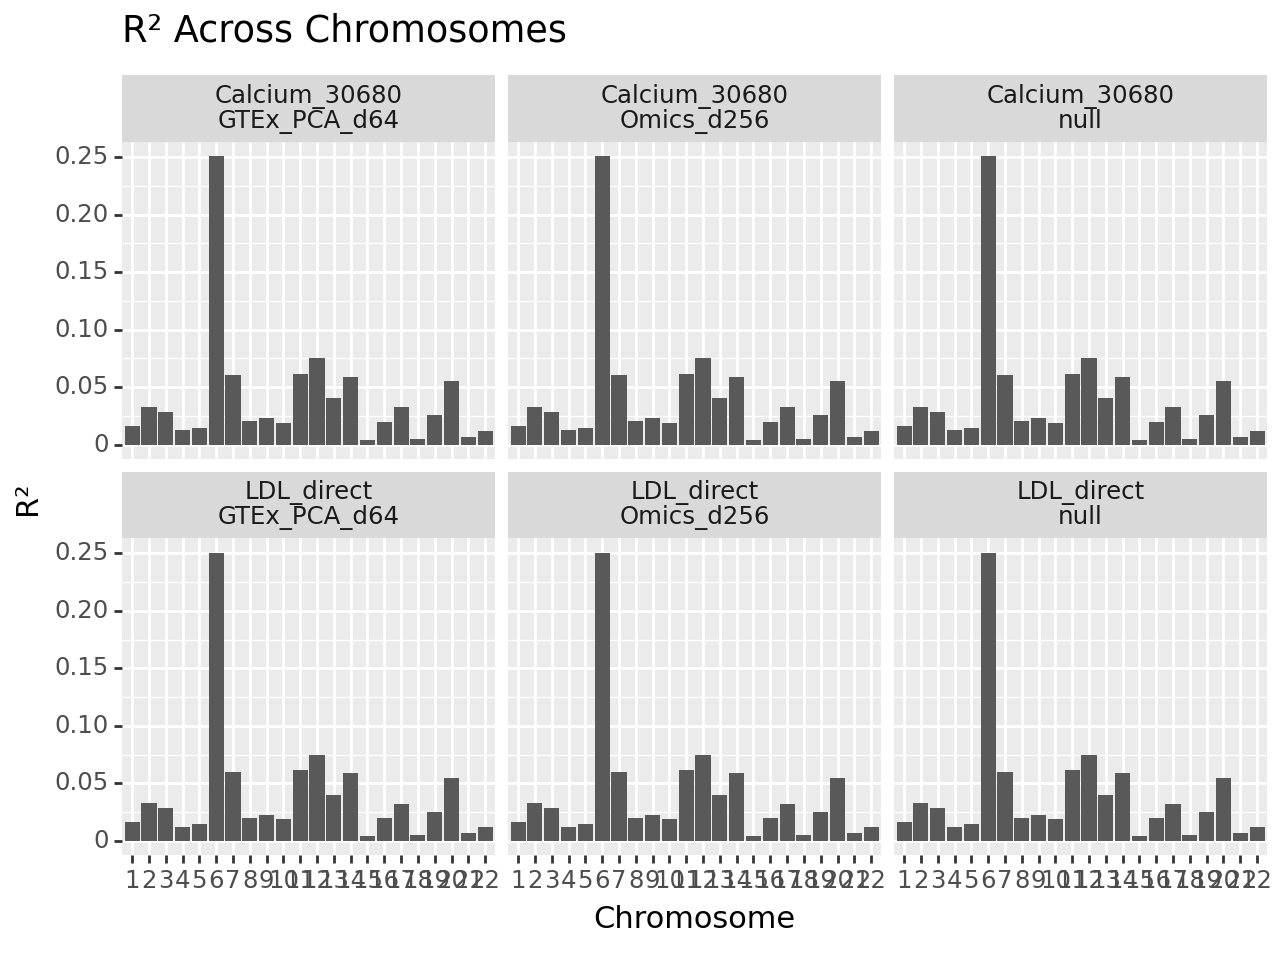

<Figure Size: (640 x 480)>

In [323]:
r2_per_chrom(results)

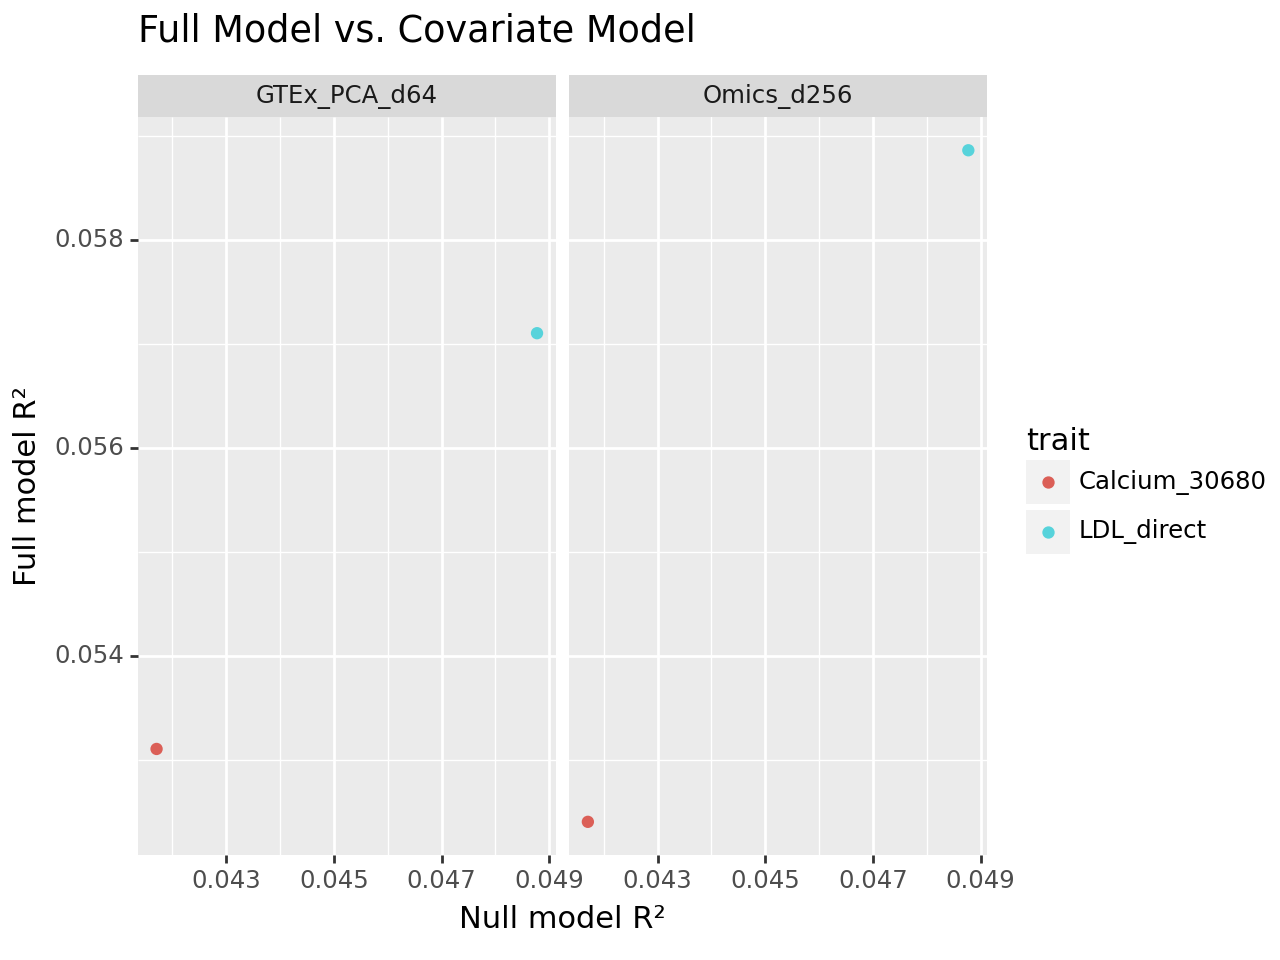

<Figure Size: (640 x 480)>

In [324]:
scatterplot_all_models(results)

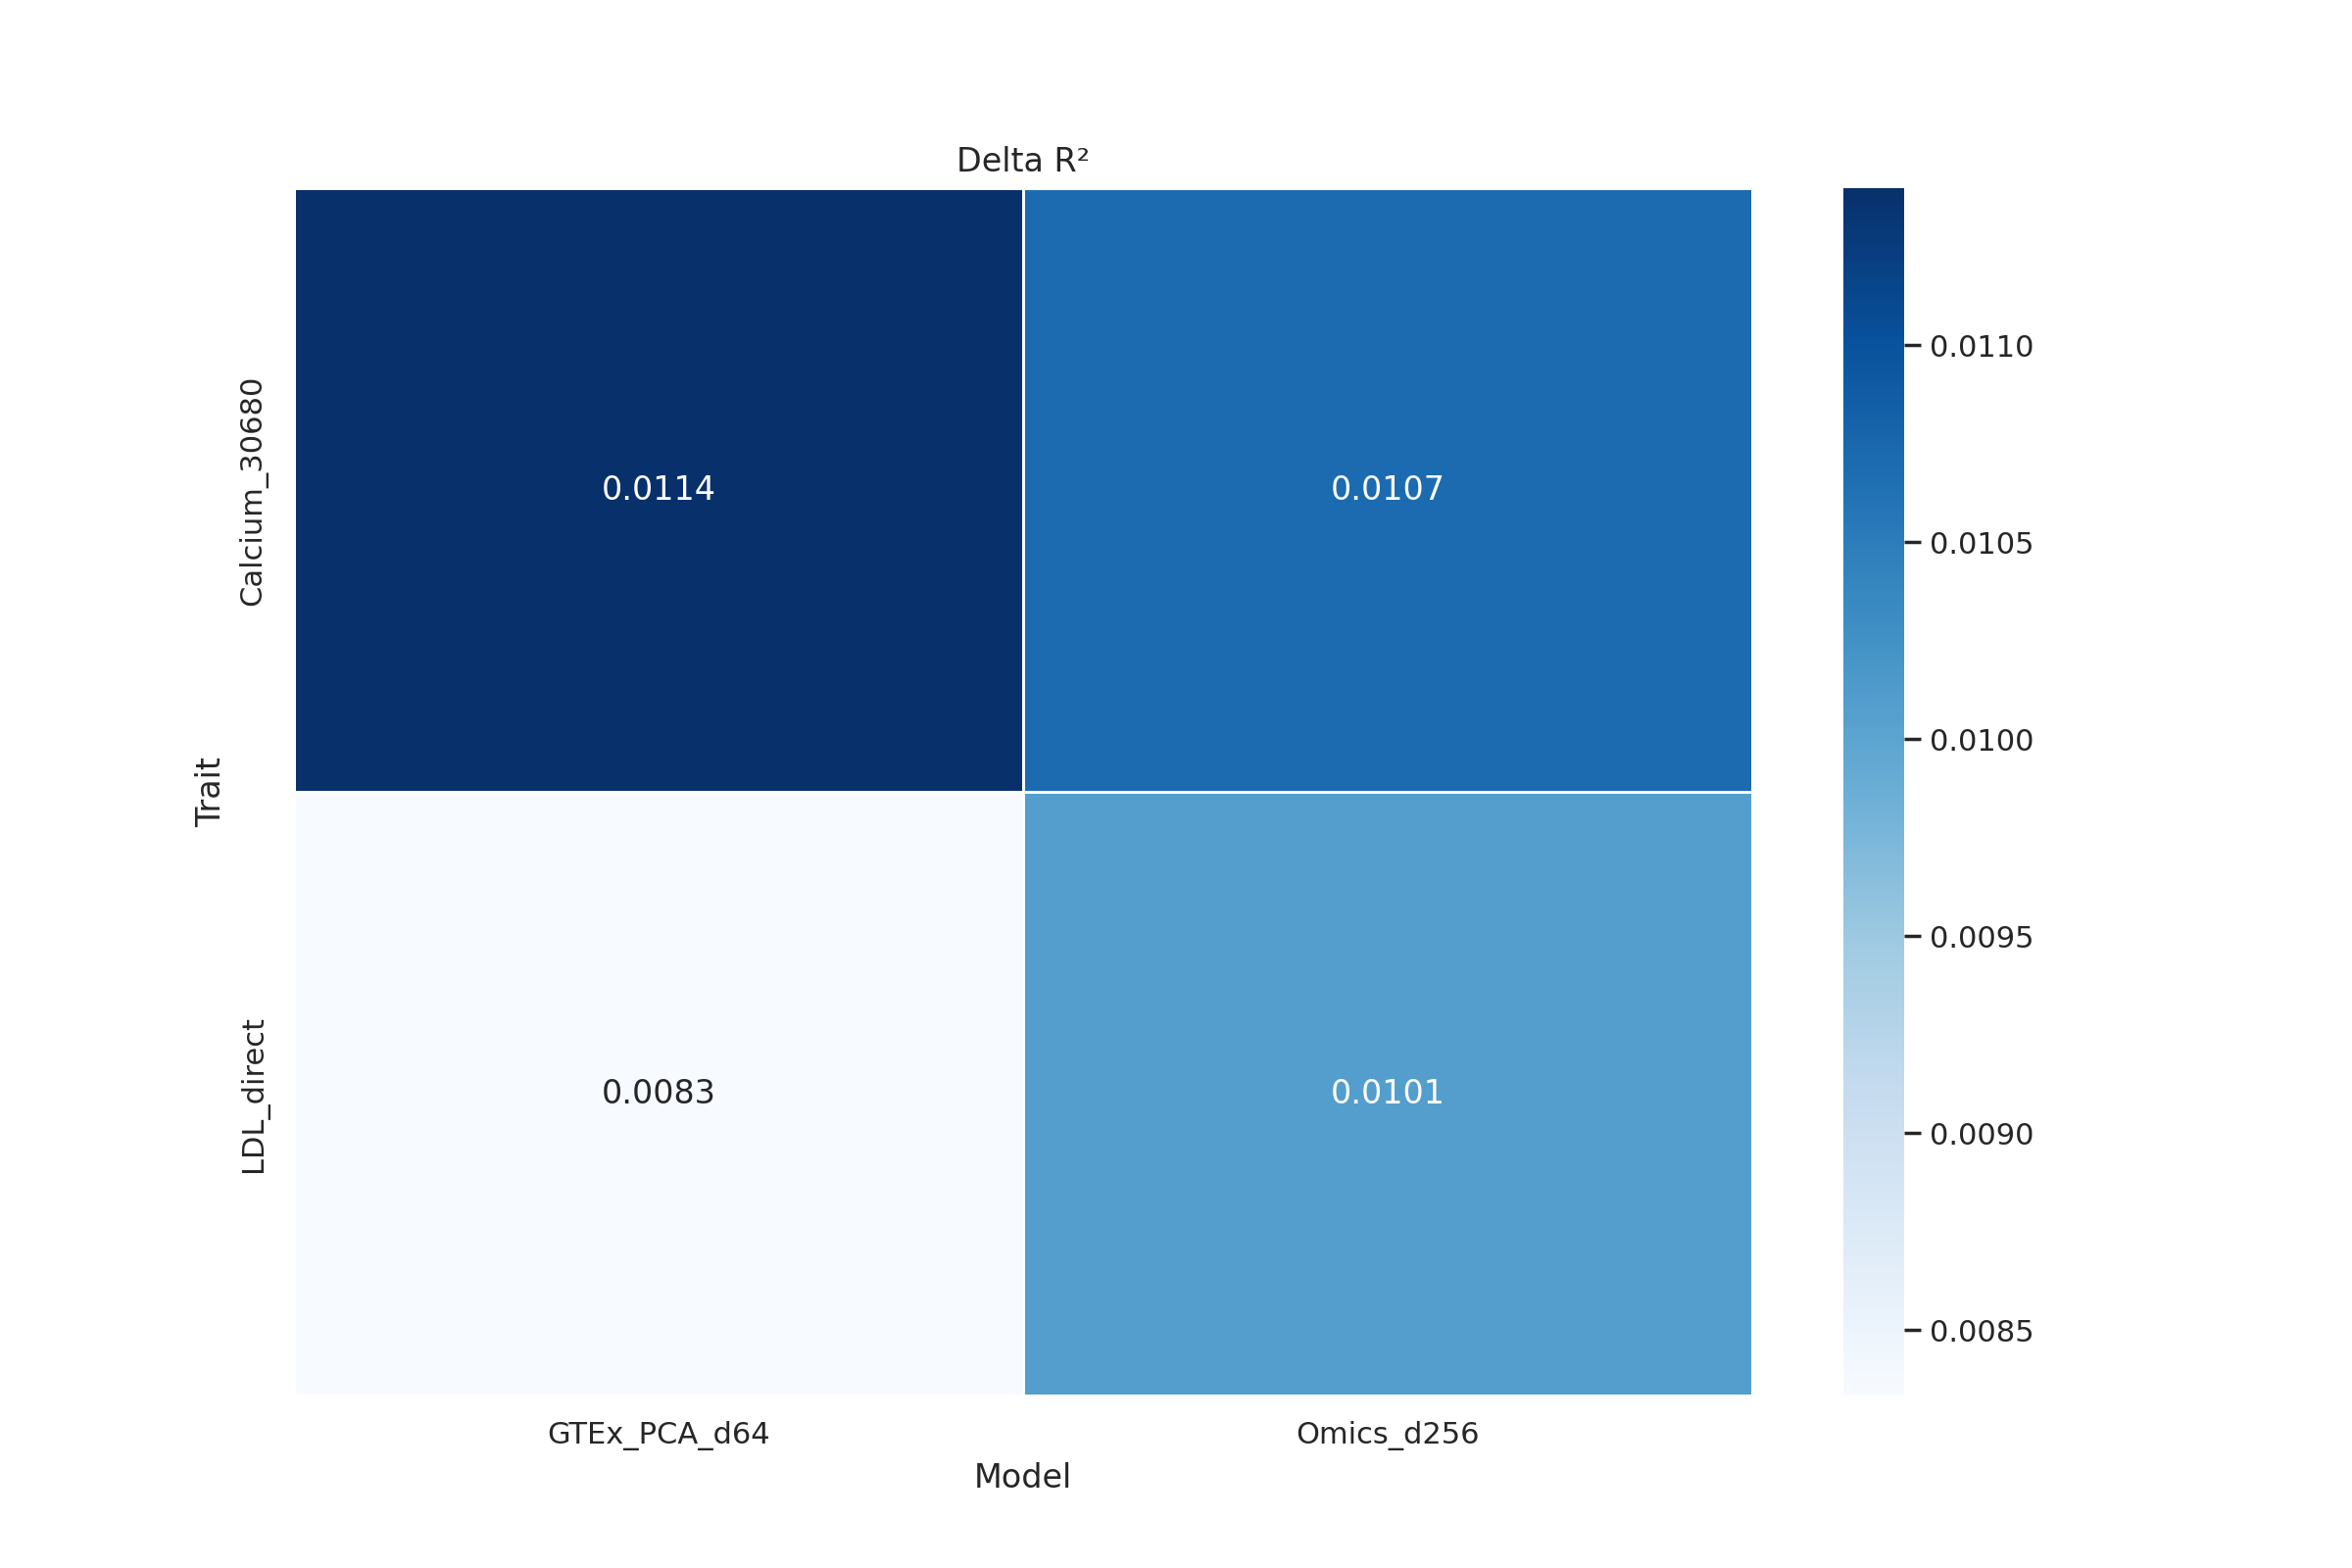

In [350]:
heatmap_models_traits(res_df)

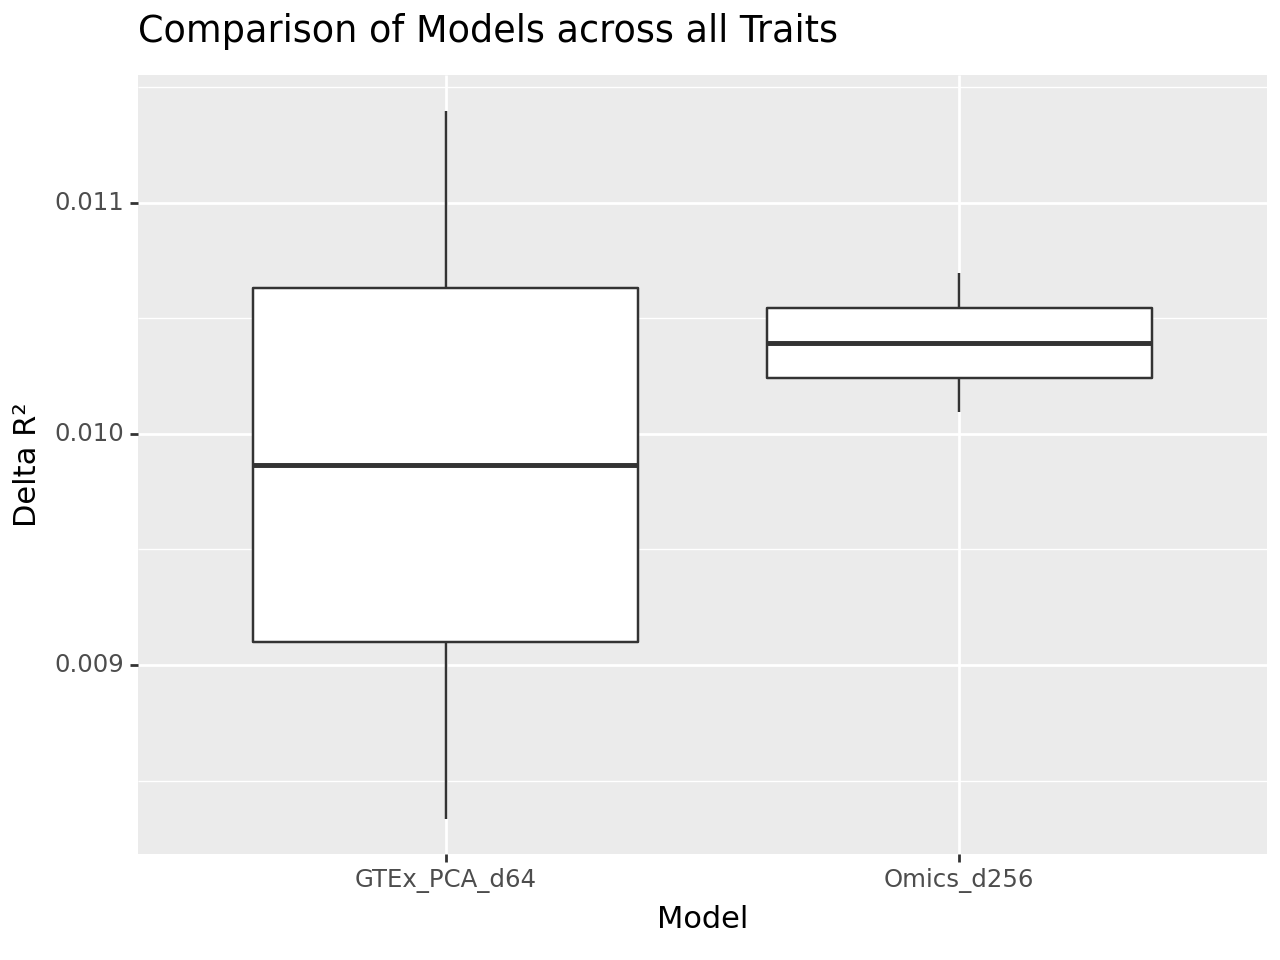

<Figure Size: (640 x 480)>

In [326]:
boxplot_all_models(res_df)

Omics_d256 p = 0.5
GTEx_PCA_d64 p = 0.5


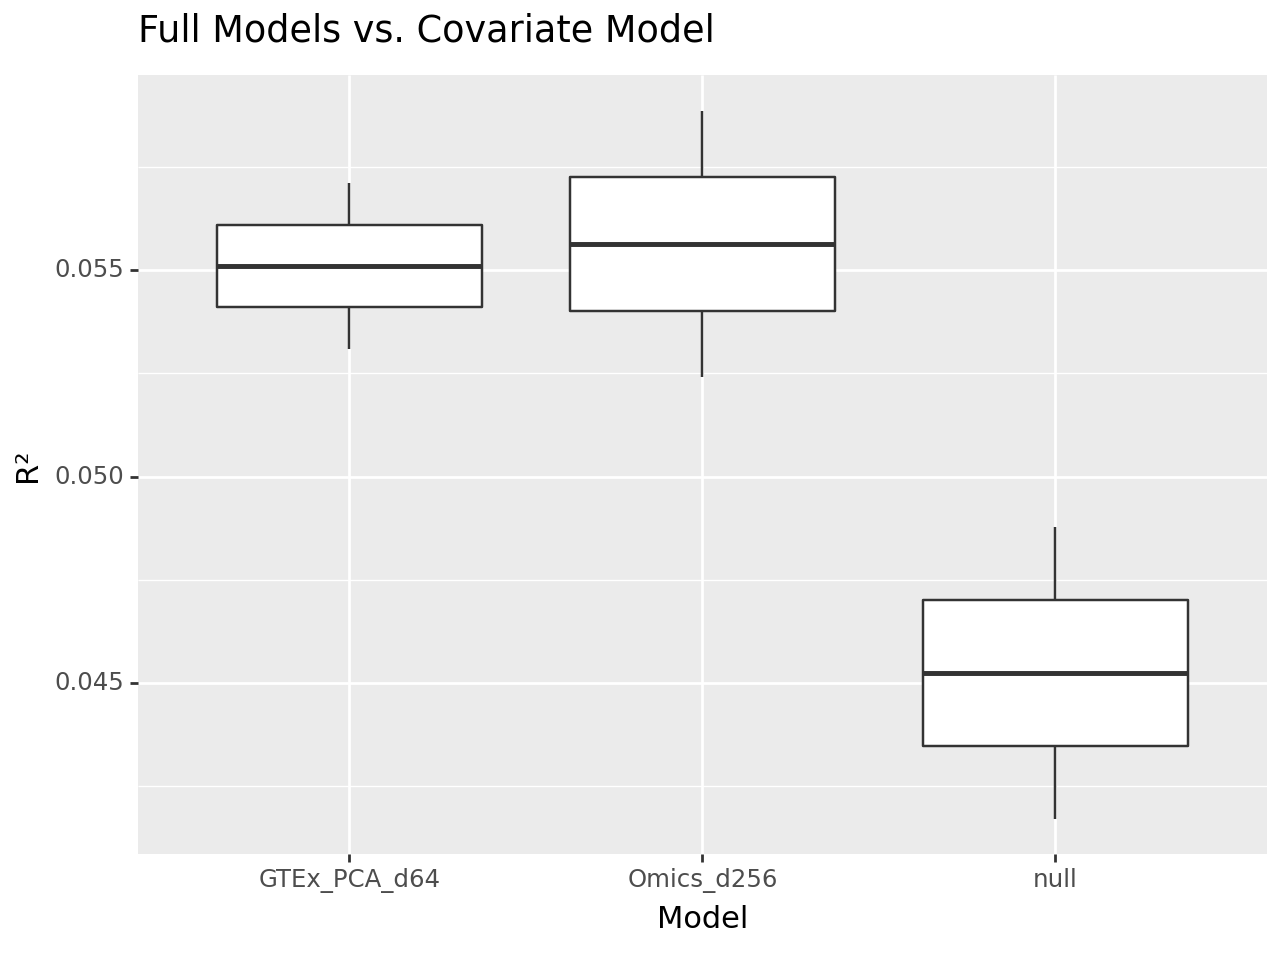

<Figure Size: (640 x 480)>

In [333]:
compare_against_null(results, alpha=0.05)